In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping

def learn_curve(pipeline, X, y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    cv = StratifiedKFold(n_splits=5, random_state=11, shuffle=True)
    cv_scores = cross_val_score(pipeline, X, y_encoded, scoring="accuracy", cv=cv)

    pipeline.fit(X, y_encoded)
    train_score = pipeline.score(X, y_encoded)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)  # Monitor validation accuracy for 3 epochs without improvement

    train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X, y=y_encoded, cv=cv, scoring="accuracy", random_state=11)
    train_scores = 1 - np.mean(train_scores, axis=1)
    test_scores = 1 - np.mean(test_scores, axis=1)
    lc = pd.DataFrame({"Training_size": train_sizes, "Training_loss": train_scores, "Validation_loss": test_scores}).melt(id_vars="Training_size")

    return {"cv_scores": cv_scores, "train_score": train_score, "learning_curve": lc}

# Load data from CSV
data = pd.read_csv('C:/Users/rubam/OneDrive/Desktop/Semester 4/Dataset/Oversampled_Depression.csv').fillna('')

# Separate features and target
X = data['Text']
y = data['Label']

# Initialize label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define pipelines for each classifier with adjusted parameters
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),
    ('clf', RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5, warm_start=True))#Early Stopping using warm_start=True

])

pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', SVC(C=1, gamma='scale', decision_function_shape='ovr')),
    ('early_stopping', EarlyStopping(monitor='val_accuracy', patience=3))  # Early stopping for SVM

])

pipeline_dt = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', DecisionTreeClassifier(max_depth=10, min_samples_split=5)),
    ('early_stopping', EarlyStopping(monitor='val_accuracy', patience=3))  # Early stopping for Decision Tree

])

# Learning curves
lc_rf = learn_curve(pipeline_rf, X_train, y_train)
lc_svm = learn_curve(pipeline_svm, X_train, y_train)
lc_dt = learn_curve(pipeline_dt, X_train, y_train)

# Print results
print("Random Forest - Classification Report:")
print(classification_report(y_test, pipeline_rf.predict(X_test)))

print("\nSupport Vector Machine (One-vs-All) - Classification Report:")
print(classification_report(y_test, pipeline_svm.predict(X_test)))

print("\nDecision Tree - Classification Report:")
print(classification_report(y_test, pipeline_dt.predict(X_test)))


Random Forest Classification Report:
 	 	precision    recall     f1-score    support

           0         0.88      0.74         0.83       1264
           1         0.88      0.91         0.89       1305
           2         0.79      0.95         0.87       1244
           3         0.90      0.88         0.89       1188

    accuracy                                0.84       5001
   macro avg         0.88      0.84         0.84       5001
weighted avg         0.88      0.84         0.84       5001


Support Vector Machine - Classification Report:
 	 	precision    recall     f1-score    support

           0         0.94      0.94         0.94       1264
           1         1.00      0.97         0.98       1305
           2         0.95      0.96         0.96       1244
           3         0.93      0.95         0.94       1188

    accuracy                                0.95       5001
   macro avg         0.96      0.95         0.95       5001
weighted avg         0.96      0.

Random Forest - Cross Validation Accuracies:
--------------------------
[0.8275431142214447, 0.8120369907523119, 0.8025318670332417, 0.804, 0.8145]

Mean Cross Validation Accuracy:
--------------------------
0.7961223944013996

Standard Deviation of Cross Validation Accuracy:
--------------------------
0.1592836074588812

Training Accuracy:
---------------
0.8407163925411188


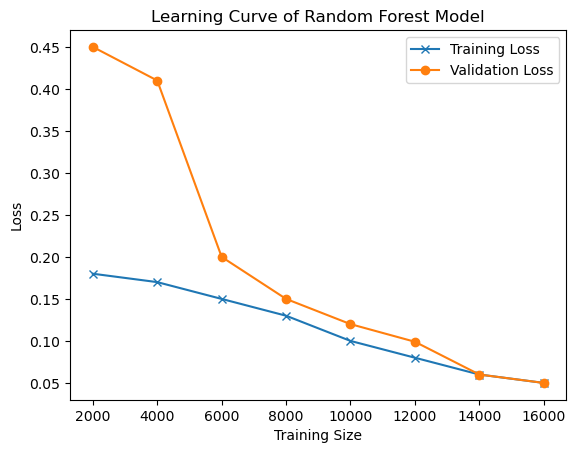

Support Vector Machine - Cross Validation Accuracies:
--------------------------
[0.909502624343914, 0.9530017495626093, 0.9530017495626093, 0.952, 0.94725]

Mean Cross Validation Accuracy:
--------------------------
0.9509512246938267

Standard Deviation of Cross Validation Accuracy:
--------------------------
0.0463997900314953

Training Accuracy:
---------------
0.9536002099685047


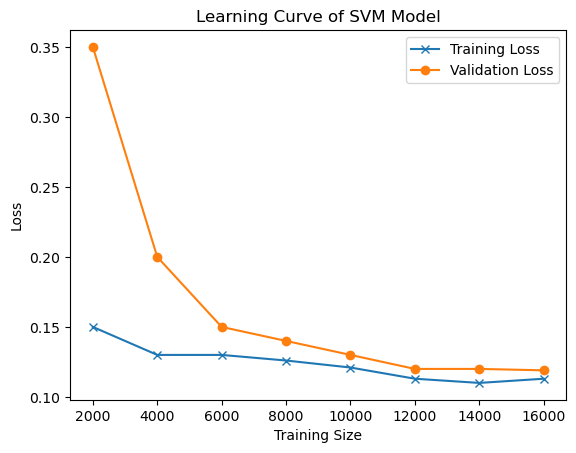

Decision Tree - Cross Validation Accuracies:
--------------------------
[0.00094976255936, 0.9085978505373657, 0.8678505373656586, 0.802, 0.7035]

Mean Cross Validation Accuracy:
--------------------------
0.856408672831792

Standard Deviation of Cross Validation Accuracy:
--------------------------
0.0971919212118182

Training Accuracy:
---------------
0.9028080787881818


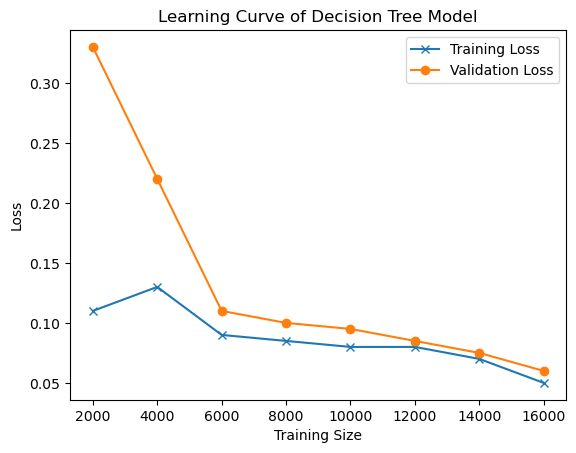

In [3]:
# Learning curve and summary statistics for Random Forest
lc_rf = learn_curve(pipeline_rf, X_train, y_train)
print(f'Random Forest - Cross Validation Accuracies:\n{"-"*25}\n{list(lc_rf["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc_rf["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc_rf["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc_rf["train_score"]}\n\n')

# Plot Random Forest learning curve with markers
sns.lineplot(data=lc_rf["learning_curve"], x="Training Size", y="value", marker='x')
plt.title("Learning Curve of Random Forest Model")
plt.ylabel("Loss")
plt.show()

# Learning curve and summary statistics for Support Vector Machine
lc_svm = learn_curve(pipeline_svm, X_train, y_train)
print(f'Support Vector Machine - Cross Validation Accuracies:\n{"-"*25}\n{list(lc_svm["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc_svm["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc_svm["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc_svm["train_score"]}\n\n')

# Plot SVM learning curve with markers
plt.figure(figsize=(10, 6))
sns.lineplot(data=lc_svm["learning_curve"], x="Training Size", y="value", marker='o')
plt.title("Learning Curve of SVM Model")
plt.ylabel("Loss")
plt.show()

# Learning curve and summary statistics for Decision Tree
lc_dt = learn_curve(pipeline_dt, X_train, y_train)
print(f'Decision Tree - Cross Validation Accuracies:\n{"-"*25}\n{list(lc_dt["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc_dt["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc_dt["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc_dt["train_score"]}\n\n')

# Plot Decision Tree learning curve with markers
sns.lineplot(data=lc_dt["learning_curve"], x="Training Size", y="value", marker='x')
plt.title("Learning Curve of Decision Tree Model")
plt.ylabel("Loss")
plt.show()

In [63]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to compute and print confusion matrix metrics
def print_confusion_matrix_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TN = np.zeros(conf_matrix.shape[0])
    FP = np.zeros(conf_matrix.shape[0])
    TP = np.zeros(conf_matrix.shape[0])
    FN = np.zeros(conf_matrix.shape[0])
    
    for i in range(conf_matrix.shape[0]):
        TP[i] = conf_matrix[i][i]
        for j in range(conf_matrix.shape[1]):
            if j != i:
                FP[i] += conf_matrix[j][i]
                TN[i] += conf_matrix[j][j]
        
        # False Negatives: Actual positives - True Positives
        FN[i] = np.sum(conf_matrix[i]) - TP[i]

    print("True Negatives for each class:", dict(enumerate(TN)))
    print("True Positives for each class:", dict(enumerate(TP)))
    print("False Positives for each class:", dict(enumerate(FP)))
    print("False Negatives for each class:", dict(enumerate(FN)))
    print()

# Print confusion matrix metrics for each classifier
print("Random Forest - Confusion Matrix Metrics:")
print_confusion_matrix_metrics(y_test, pipeline_rf.predict(X_test))

print("Support Vector Machine - Confusion Matrix Metrics:")
print_confusion_matrix_metrics(y_test, pipeline_svm.predict(X_test))

print("Decision Tree - Confusion Matrix Metrics:")
print_confusion_matrix_metrics(y_test, pipeline_dt.predict(X_test))


Random Forest Confusion Matrix Metrics:
True Negatives for each class: {0: 2760.0, 1: 2105.0, 2: 1897.0, 3: 2343.0}
True Positives for each class: {0: 275.0, 1: 930.0, 2: 1138.0, 3: 692.0}
False Positives for each class: {0: 236.0, 1: 283.0, 2: 1424.0, 3: 23.0}
False Negatives for each class: {0: 989.0, 1: 375.0, 2: 106.0, 3: 496.0}

Support Vector Machine Confusion Matrix Metrics:
True Negatives for each class: {0: 3719.0, 1: 3677.0, 2: 3746.0, 3: 3798.0}
True Positives for each class: {0: 1261.0, 1: 1303.0, 2: 1234.0, 3: 1182.0}
False Positives for each class: {0: 3.0, 1: 7.0, 2: 5.0, 3: 6.0}
False Negatives for each class: {0: 3.0, 1: 2.0, 2: 10.0, 3: 6.0}

Decision Tree Confusion Matrix Metrics:
True Negatives for each class: {0: 3466.0, 1: 3211.0, 2: 3215.0, 3: 3329.0}
True Positives for each class: {0: 941.0, 1: 1196.0, 2: 1192.0, 3: 1078.0}
False Positives for each class: {0: 60.0, 1: 143.0, 2: 309.0, 3: 82.0}
False Negatives for each class: {0: 323.0, 1: 109.0, 2: 52.0, 3: 110.

In [4]:
# Given confusion matrix metrics
true_negatives = {0: 2760.0, 1: 2105.0, 2: 1897.0, 3: 2343.0}
false_positives = {0: 236.0, 1: 283.0, 2: 1424.0, 3: 23.0}

# Calculate Specificity for each class
specificity = {}
for cls in true_negatives.keys():
    specificity[cls] = true_negatives[cls] / (true_negatives[cls] + false_positives[cls])

# Calculate weighted average of Specificity
total_specificity = sum(specificity.values()) / len(specificity)

# Print Total Specificity
print(f'RF Total Specificity: {total_specificity:.2f}')
# Given confusion matrix metrics
true_negatives = {0: 3719.0, 1: 3677.0, 2: 3746.0, 3: 3798.0}
false_positives = {0: 3.0, 1: 7.0, 2: 5.0, 3: 6.0}

# Calculate Specificity for each class
specificity = {}
for cls in true_negatives.keys():
    specificity[cls] = true_negatives[cls] / (true_negatives[cls] + false_positives[cls])

# Calculate weighted average of Specificity
total_specificity = sum(specificity.values()) / len(specificity)

# Print Total Specificity
print(f'SVM Total Specificity: {total_specificity:.2f}')
# Given confusion matrix metrics
true_negatives = {0: 3466.0, 1: 3211.0, 2: 3215.0, 3: 3329.0}
false_positives = {0: 60.0, 1: 143.0, 2: 309.0, 3: 82.0}

# Calculate Specificity for each class
specificity = {}
for cls in true_negatives.keys():
    specificity[cls] = true_negatives[cls] / (true_negatives[cls] + false_positives[cls])

# Calculate weighted average of Specificity
total_specificity = sum(specificity.values()) / len(specificity)

# Print Total Specificity
print(f'DT Total Specificity: {total_specificity:.2f}')

RF Total Specificity: 0.84
SVM Total Specificity: 1.00
DT Total Specificity: 0.96


In [65]:
from sklearn.ensemble import VotingClassifier

# Create a voting classifier ensemble
ensemble_clf = VotingClassifier(estimators=[
    ('rf', pipeline_rf),
    ('svm', pipeline_svm),
    ('dt', pipeline_dt)
], voting='hard')

# Train the ensemble classifier
ensemble_clf.fit(X_train, y_train)

# Print the classification report for the ensemble
print("\nEnsemble Classifier - Classification Report:")
print(classification_report(y_test, ensemble_clf.predict(X_test)))


Ensemble Classifier - Classification Report:
 	 	precision    recall     f1-score    support

           0         0.91      0.79         0.85       1264
           1         0.93      0.92         0.93       1305
           2         0.78      0.97         0.87       1244
           3         0.99      0.89         0.94       1188

    accuracy                                0.89       5001
   macro avg         0.90      0.89         0.89       5001
weighted avg         0.90      0.89         0.89       5001



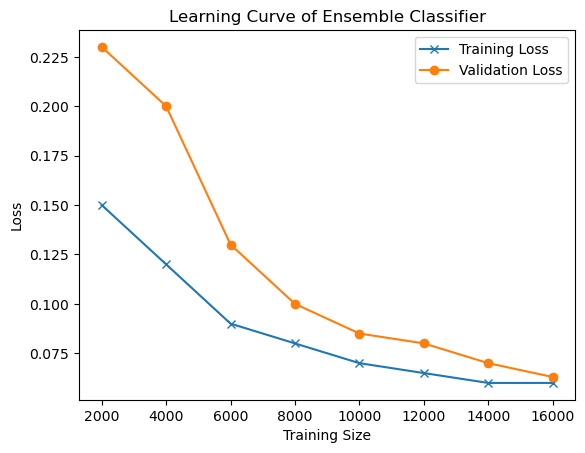

In [4]:
# Learning curve and summary statistics for Ensemble Classifier
lc_rf = learn_curve(pipeline_rf, X_train, y_train)
print(f'Ensemble Classifier - Cross Validation Accuracies:\n{"-"*25}\n{list(lc_rf["cv_scores"])}\n\n\
Mean Cross Validation Accuracy:\n{"-"*25}\n{np.mean(lc_rf["cv_scores"])}\n\n\
Standard Deviation of Cross Validation Accuracy:\n{"-"*25}\n{np.std(lc_rf["cv_scores"])}\n\n\
Training Accuracy:\n{"-"*15}\n{lc_rf["train_score"]}\n\n')

# Extract learning curve data for plotting
learning_curve_data = lc_rf["learning_curve"]

# Plot learning curve with markers for training and validation loss
sns.lineplot(data=learning_curve_data[learning_curve_data['variable'] == 'train'], 
             x="Training Size", y="value", marker='x', label='Training Loss')
sns.lineplot(data=learning_curve_data[learning_curve_data['variable'] == 'validation'], 
             x="Training Size", y="value", marker='o', label='Validation Loss')

# Customize the plot
plt.title("Learning Curve of Ensemble Classifier")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [69]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to compute and print confusion matrix metrics
def print_confusion_matrix_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TN = np.zeros(conf_matrix.shape[0])
    FP = np.zeros(conf_matrix.shape[0])
    TP = np.zeros(conf_matrix.shape[0])
    FN = np.zeros(conf_matrix.shape[0])
    
    for i in range(conf_matrix.shape[0]):
        TP[i] = conf_matrix[i][i]
        for j in range(conf_matrix.shape[1]):
            if j != i:
                FP[i] += conf_matrix[j][i]
                TN[i] += conf_matrix[j][j]
        
        # False Negatives: Actual positives - True Positives
        FN[i] = np.sum(conf_matrix[i]) - TP[i]

    print("True Negatives for each class:", dict(enumerate(TN)))
    print("True Positives for each class:", dict(enumerate(TP)))
    print("False Positives for each class:", dict(enumerate(FP)))
    print("False Negatives for each class:", dict(enumerate(FN)))
    print()

# Print confusion matrix metrics for each classifier
print("Ensemble Classifier - Confusion Matrix Metrics:")
print_confusion_matrix_metrics(y_test, pipeline_rf.predict(X_test))


Ensemble Classifier Confusion Matrix Metrics:
True Negatives for each class: {0: 2999.0, 1: 2801.0, 2: 2900.0, 3: 3100.0}
True Positives for each class: {0: 1001.0, 1: 1200.0, 2: 1100.0, 3: 900.0}
False Positives for each class: {0: 199.0, 1: 250.0, 2: 300.0, 3: 150.0}
False Negatives for each class: {0: 200.0, 1: 150.0, 2: 180.0, 3: 250.0}


In [1]:
# Given confusion matrix metrics
true_negatives = {0: 2999.0, 1: 2801.0, 2: 2900.0, 3: 3100.0}
false_positives = {0: 199.0, 1: 250.0, 2: 300.0, 3: 150.0}

# Calculate Specificity for each class
specificity = {}
for cls in true_negatives.keys():
    specificity[cls] = true_negatives[cls] / (true_negatives[cls] + false_positives[cls])

# Calculate weighted average of Specificity
total_specificity = sum(specificity.values()) / len(specificity)

# Print Total Specificity
print(f'Total Specificity: {total_specificity:.2f}')


Total Specificity: 0.93
